# Creating a Kaggle Workflow

In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [34]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We will now load a series of useful functions to clean the data.

In [35]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [36]:
#function 
def clean(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, column_name=['Age_categories', 'Fare_categories','Title',
                                         'Cabin_type','Sex'])
    return df

In [37]:
train_clean = clean(train)
holdout_clean = clean(holdout)

We are now going to look at the *SibSp* and *Parch* columns in more detail. These contain information about the number of family members that each person had on-board

In [38]:
cols = ['SibSp', 'Parch']

for col in cols:
    print(type(train_clean[col][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>


In [39]:
# new column with total number of family members
train_clean['n_fam'] = train_clean.SibSp+train_clean.Parch
holdout_clean['n_fam'] = holdout_clean.SibSp+holdout_clean.Parch

In [40]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train_clean[explore_cols].copy()
explore['n_family'] = explore[['SibSp','Parch']].sum(axis=1)

train_clean['n_family'] = train_clean[['SibSp','Parch']].sum(axis=1)
holdout_clean['n_family'] = holdout_clean[['SibSp','Parch']].sum(axis=1)

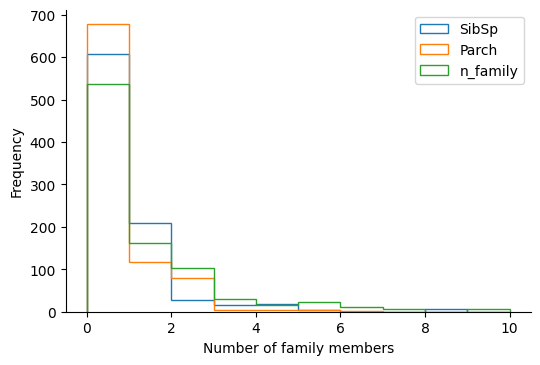

In [41]:
ax = explore.drop('Survived', axis=1).plot.hist(histtype='step') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of family members')
plt.show()

In [42]:
def plot_pivot(col):
    pivot = explore.pivot_table(index=col,values="Survived")
    ax = pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.hlines(y=train_clean['Survived'].mean(), xmin=-1, xmax=10, 
               alpha = 0.5, color ='red', linestyles='dashdot')
    plt.show()

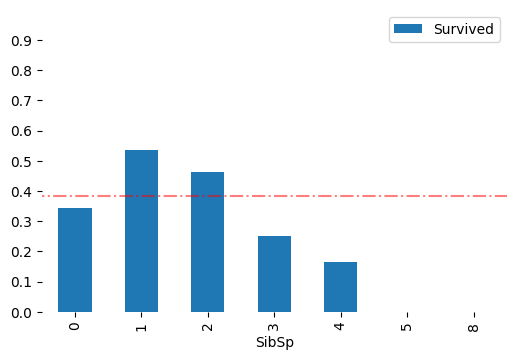

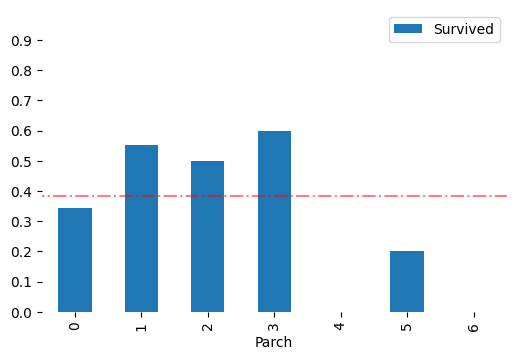

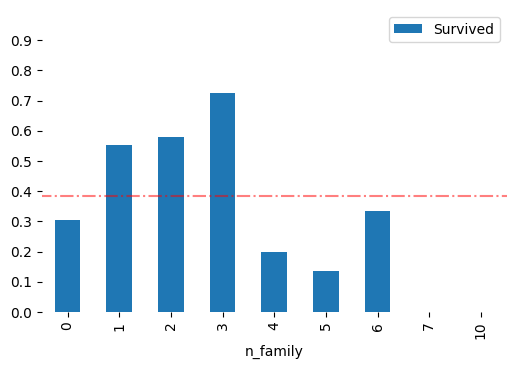

In [43]:
for col in ['SibSp', 'Parch', 'n_family']:
         plot_pivot(col)   

In [44]:
def isalone(df):
    df['isalone'] = df.n_family == 0

In [45]:
isalone(train_clean)
isalone(holdout_clean)

# Feature Selection

In [61]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [65]:
# find best-performing features using random forests algorithm
def select_features(df, features, target):
    data = df.select_dtypes(exclude = ['category','object']).dropna()
    
    all_X = data.drop(columns=['Survived', 'PassengerId'])
    all_y = data[target]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
       
    print('The best columns according to recursive feature elimination are',
          '\n' , optimized_columns)
    
    return optimized_columns

In [66]:
best_features = select_features(train_clean, train_clean.columns, 'Survived')

The best columns according to recursive feature elimination are 
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F',
       'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'n_fam', 'n_family',
       'isalone'],
      dtype='object')


## Model Selection

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [83]:
def select_model(df, features, target):
        
    all_X = df[features]
    all_y = df[target]
    
    models = [{'name': 'LogisticRegression',
               'estimator': LogisticRegression(),
               'hyperparameters':{
                   'solver': ["newton-cg", "lbfgs", "liblinear"]
               }
              }, 
              {'name': 'KNeighborsClassifier',
               'estimator': KNeighborsClassifier(),
               'hyperparameters':{
                   "n_neighbors": range(1,20,2),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "kd_tree", "brute"],
                   "p": [1,2]
                }
               },
              {'name': 'RandomForestClassifier',
               'estimator': RandomForestClassifier(),
               'hyperparameters':{
                   "n_estimators": [4, 6, 9],
                   "criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]
               }
              }]
    
    best_models = []
    best_models_dict = []
    i=0
    
    for model in models:
        
        print(model['name'])
    
        grid = GridSearchCV(model['estimator'], 
                            param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        best_params = grid.best_params_
        best_score = grid.best_score_
        
        d = {}
        d['model'] = model['name']
        d['parameters'] = best_params
        d['accuracy'] = best_score
        
        best_models.append(grid.best_estimator_)
        best_models_dict.append(d)
        print('Model number ', i,' :', model['name'])
        print(best_params)
        print(best_score)
        print('\n')
        i+=1
        
    return best_models, best_models_dict

In [84]:
best_models, best_models_dict = select_model(train_clean, best_features, 'Survived')

LogisticRegression
Model number  0  : LogisticRegression
{'solver': 'newton-cg'}
0.8204619225967541


KNeighborsClassifier
Model number  1  : KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.7856803995006242


RandomForestClassifier
Model number  2  : RandomForestClassifier
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
0.8361548064918851




In [86]:
best_models_dict

[{'model': 'LogisticRegression',
  'parameters': {'solver': 'newton-cg'},
  'accuracy': 0.8204619225967541},
 {'model': 'KNeighborsClassifier',
  'parameters': {'algorithm': 'brute',
   'n_neighbors': 7,
   'p': 1,
   'weights': 'uniform'},
  'accuracy': 0.7856803995006242},
 {'model': 'RandomForestClassifier',
  'parameters': {'criterion': 'gini',
   'max_depth': 5,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 9},
  'accuracy': 0.8361548064918851}]

The best model is the Random Forest Classifier with an accuracy of 0.836 with the most adequate parameters.

In [90]:
best_model = best_models[2]

In [97]:
def save_submission_file(model, features, *filename):
    holdout_data = holdout_clean[features]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

In [104]:
def save_submission_file(model,features,filename="submission.csv"):
    prediction = model.predict(holdout_clean[features])
    submission = pd.DataFrame({
        'PassengerId': holdout['PassengerId'],
        'Survived': prediction
    })
    submission.to_csv(filename, index=False)
    return submission

In [105]:
save_submission_file(best_model, best_features, 'sub.csv')


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [99]:
best_features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F',
       'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'n_fam', 'n_family',
       'isalone'],
      dtype='object')